# Direct Ptychography Tutorial 03

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/ophusgroup/apmc2025-4dstem-workshop/blob/main/notebooks/try-it-yourself/06.direct_ptychography_03.ipynb)

This is the third and last tutorial notebook in the direct ptychography series.  
In this tutorial notebook we will cover:
- Optimum bright-field STEM reconstructions
- Wigner distribution deconvolution reconstructions
- Segmented-detector reconstructions

### Downloads
This tutorial uses the following datasets:
- [dpc_STO_simulation.h5](https://drive.google.com/file/d/1Ml1Ga4-U0ZcTJxq0LVyTJDIVfnBuyd81/view?usp=drive_link)

### Acknowledgements

This tutorial was created by the py4DSTEM `phase_contrast` team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (cophus@stanford.edu)

Last updated: 2024 Feb 01

## Introduction

So far, we have only used the (phase-compensated) single-side band (SSB) method. There are two closely-related techniques which have been proposed to perform better for low-dose datasets. Those are:  
- Optimum bright-field (OBF) STEM: [[Ooe, K., et al. (2021), Ultramic, 220, 113133]](https://doi.org/10.1016/j.ultramic.2020.113133)
- Wigner distribution deconvolution (WDD): [[Yang, H., et al. (2017), Ultramic, 180, 173-179]](https://doi.org/10.1016/j.ultramic.2017.02.006)

In [1]:
%pip install py4DSTEM > /dev/null 2>&1

In [2]:
import numpy as np
import py4DSTEM
import matplotlib.pyplot as plt

print(py4DSTEM.__version__)
%matplotlib inline

cupyx.jit.rawkernel is experimental. The interface can change in the future.


0.14.18


We'll use the same, in-focus, dataset as the one we used in `direct_ptychography_01.ipynb`.

In [3]:
# Get the 4DSTEM data
py4DSTEM.io.gdrive_download(
    id_ = 'https://drive.google.com/uc?id=1Ml1Ga4-U0ZcTJxq0LVyTJDIVfnBuyd81',
    destination = '/content/',
    filename = 'dpc_STO_simulation.h5',
    overwrite=True
)

Downloading...
From: https://drive.google.com/uc?id=1Ml1Ga4-U0ZcTJxq0LVyTJDIVfnBuyd81
To: /content/dpc_STO_simulation.h5
100%|██████████| 75.5M/75.5M [00:00<00:00, 139MB/s]


In [4]:
file_path = '/content/'
file_data = file_path + 'dpc_STO_simulation.h5'

dataset = py4DSTEM.read(file_data)
dataset.crop_Q((24,-24,24,-24))

DataCube( A 4-dimensional array of shape (32, 32, 48, 48) called 'datacube',
          with dimensions:

              Rx = [0.0,0.12328531250000001,0.24657062500000002,...] A
              Ry = [0.0,0.12328531250000001,0.24657062500000002,...] A
              Qx = [0.0,1.0595062826244177,2.1190125652488354,...] mrad
              Qy = [0.0,1.0595062826244177,2.1190125652488354,...] mrad
)

## SSB Algorithm Variants

First, let's reproduce the phase-compensated SSB reconstruction from `direct_ptychography_01.ipynb`:

Calculating center of mass: 100%|██████████| 1024/1024 [00:00<00:00, 8019.79probe position/s]
Best fit rotation forced to -15 degrees.
100%|██████████| 1024/1024 [00:02<00:00, 342.46it/s]


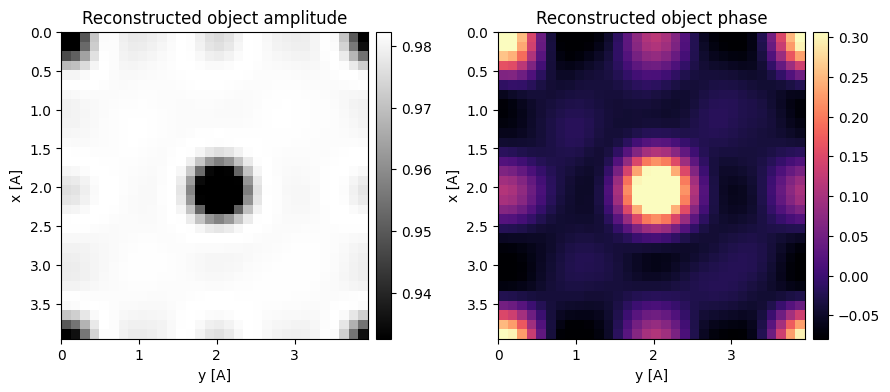

In [5]:
energy = 200e3
semiangle_cutoff = 20

ssb = py4DSTEM.process.phase.SSB(
    energy=energy,
    datacube=dataset,
    semiangle_cutoff=semiangle_cutoff,
    verbose=True,
).preprocess(
    plot_center_of_mass=False,
    plot_rotation=False,
    plot_overlap_trotters=False,
    force_com_rotation=-15,
    crop_around_bf_disk=False,
).reconstruct(
).visualize(
)

Optimum bright-field (OBF) STEM also compensates for the phase in the double minus triple overlap trotters, albeit using a different normalization.  
In py4DSTEM, this can be invoked using the `OBF` class.

Calculating center of mass: 100%|██████████| 1024/1024 [00:00<00:00, 43286.88probe position/s]
Best fit rotation forced to -15 degrees.
100%|██████████| 1024/1024 [00:01<00:00, 922.49it/s]


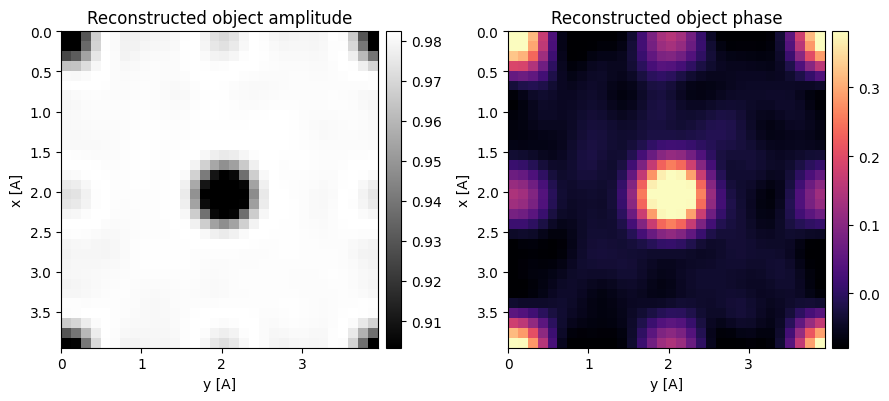

In [6]:
obf = py4DSTEM.process.phase.OBF(
    energy=energy,
    datacube=dataset,
    semiangle_cutoff=semiangle_cutoff,
    verbose=True,
).preprocess(
    plot_center_of_mass=False,
    plot_rotation=False,
    plot_overlap_trotters=False,
    force_com_rotation=-15,
    crop_around_bf_disk=False,
).reconstruct(
).visualize(
)

Wigner distribution deconvolution (WDD) is a more involved technique which attempts to fully deconvolve the effects of the probe from the object.  
The method uses a [Wiener-filter](https://en.wikipedia.org/wiki/Wiener_filter) to avoid dividing by zero and boosting noise.  

It can be invoked in py4DSTEM using the `WDD` class and requires the user specify the (relative) Wiener filtering parameter (with reasonable values between 0.01 - 0.1).

Calculating center of mass: 100%|██████████| 1024/1024 [00:00<00:00, 45614.47probe position/s]
Best fit rotation forced to -15 degrees.
100%|██████████| 1024/1024 [00:01<00:00, 1171.38it/s]


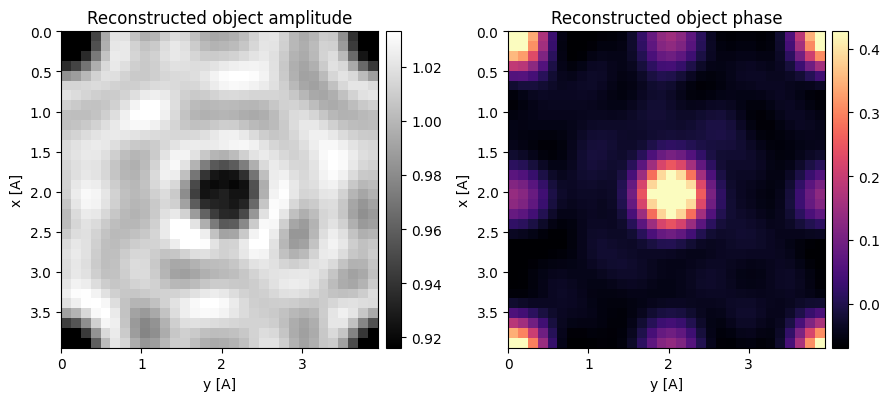

In [7]:
wdd = py4DSTEM.process.phase.WDD(
    energy=energy,
    datacube=dataset,
    semiangle_cutoff=semiangle_cutoff,
    verbose=True,
).preprocess(
    plot_center_of_mass=False,
    plot_rotation=False,
    plot_overlap_trotters=False,
    force_com_rotation=-15,
    crop_around_bf_disk=False,
).reconstruct(
    relative_wiener_epsilon=0.01,
).visualize(
)

The reconstructions all look quite similar, with OBF and WDD showing (slightly) higher information limits

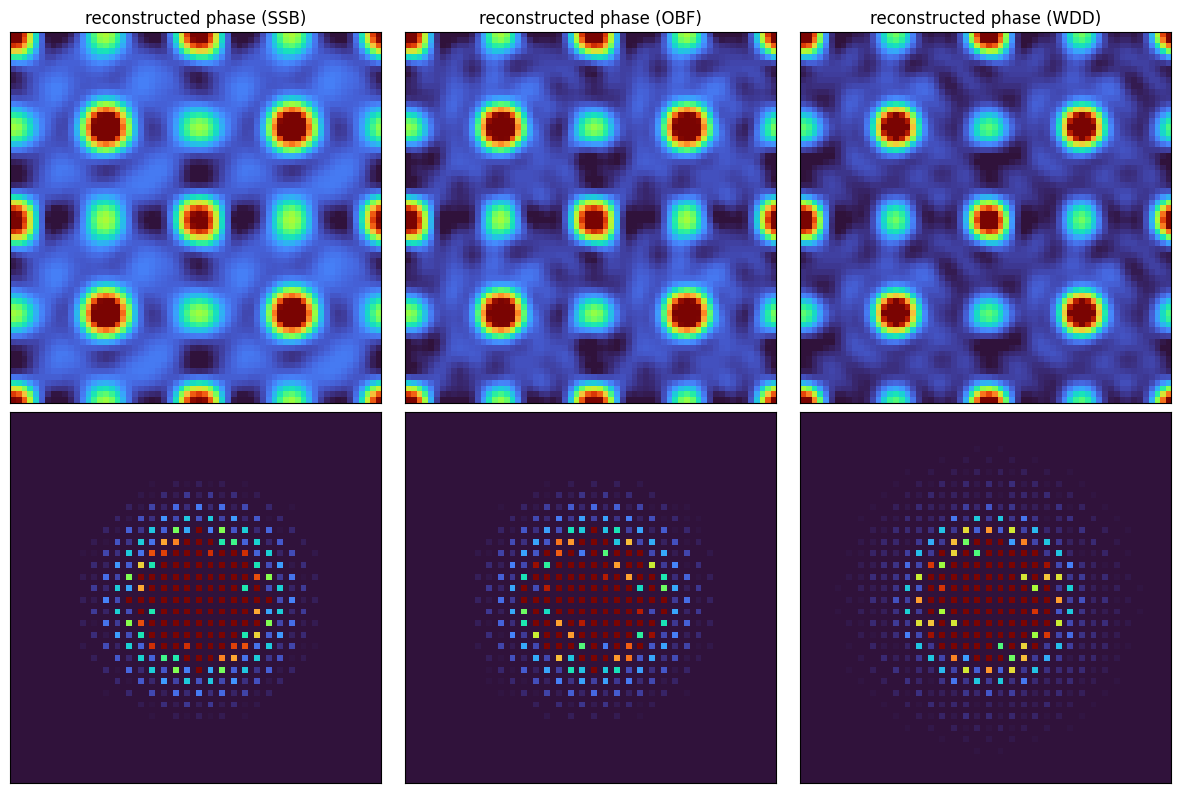

In [8]:
fig, axs = plt.subplots(2,3,figsize=(12,8))

for ax, arr, title in zip(
    axs[0],
    (np.angle(ssb.object),np.angle(obf.object),np.angle(wdd.object)),
    ('reconstructed phase (SSB)','reconstructed phase (OBF)','reconstructed phase (WDD)')
):
    py4DSTEM.show(
        np.tile(arr,(2,2)),
        figax=(fig,ax),
        cmap='turbo',
        ticks=False,
        title=title,
    )

for ax, arr in zip(
    axs[1],
    (np.angle(ssb.object),np.angle(obf.object),np.angle(wdd.object))
):
    py4DSTEM.show(
        np.tile(arr,(2,2)),
        figax=(fig,ax),
        cmap='turbo',
        show_fft=True,
        apply_hanning_window=False,
        ticks=False,
    )

fig.tight_layout()

## Segmented Detector Datasets

SSB and OBF are additionally very useful in post-processing segmented-detector datasets.  
To see this, we'll post-process our 4D-data using an annular detector with 6 segments.

In [9]:
def annular_segmented_detectors(
    energy,
    gpts,
    sampling,
    n_angular_bins,
    rotation_offset = 0,
    inner_radius = 0,
    outer_radius = np.inf,
):
    """ """
    nx,ny = gpts
    sx,sy = sampling
    wavelength = py4DSTEM.process.utils.electron_wavelength_angstrom(energy)

    alpha_x = np.fft.fftfreq(nx,sx)*wavelength
    alpha_y = np.fft.fftfreq(ny,sy)*wavelength

    alpha = np.sqrt(alpha_x[:,None]**2 + alpha_y[None,:]**2)
    radial_mask = ((inner_radius*1e-3 <= alpha) & (alpha < outer_radius*1e-3))

    theta = (np.arctan2(alpha_y[None,:], alpha_x[:,None]) + rotation_offset) % (2 * np.pi)
    angular_bins = np.floor(n_angular_bins * (theta / (2 * np.pi))) + 1
    angular_bins *= radial_mask.astype("int")

    angular_bins = [np.fft.fftshift((angular_bins == i).astype("int")) for i in range(1,n_angular_bins+1)]
    return angular_bins

def create_segmented_4d_dataset_using_virtual_detectors(dc,masks):
    """ """

    masks_np = np.array(masks).astype(np.bool_)

    preprocessed_data = np.zeros(dc.shape,dtype=np.float32)
    for mask in masks_np:
        val = np.sum(dc.data*mask,axis=(-1,-2)) / np.sum(mask)
        preprocessed_data[...,mask] = val[:,:,None]

    preprocessed_dataset = py4DSTEM.DataCube(preprocessed_data,calibration=dc.calibration.copy())
    return preprocessed_dataset

segmented_detector_masks = annular_segmented_detectors(
    energy=energy,
    gpts=dataset.Qshape,
    sampling=ssb.sampling,
    n_angular_bins = 4,
    inner_radius = semiangle_cutoff/2,
    outer_radius=semiangle_cutoff,
)

segmented_dataset = create_segmented_4d_dataset_using_virtual_detectors(dataset,segmented_detector_masks)

We plot the mean diffraction pattern alongside the segmented detector masks to emphasize the vast reduction in information encoded in this dataset:

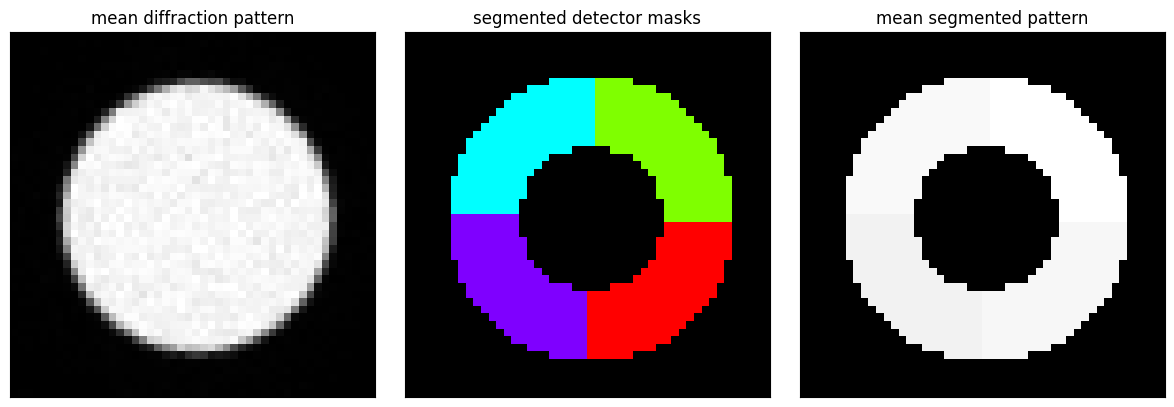

In [10]:
fig, axs = plt.subplots(1,3,figsize=(12,4))

py4DSTEM.show(
    dataset.data.mean((0,1)),
    ticks=False,
    figax=(fig,axs[0]),
    title="mean diffraction pattern",
)

py4DSTEM.show(
    segmented_detector_masks,
    combine_images=True,
    ticks=False,
    figax=(fig,axs[1]),
    title="segmented detector masks",
)

py4DSTEM.show(
    segmented_dataset.data.mean((0,1)),
    combine_images=True,
    ticks=False,
    figax=(fig,axs[2]),
    title="mean segmented pattern",
    vmin=0,vmax=1,
)

fig.tight_layout()

We can then use this pre-processed DataCube in the `SSB` and `OBF` classes, by passing a `virtual_detector_masks` argument in `reconstruct`.  
Note this accepts "corner-centered" masks.

Calculating center of mass: 100%|██████████| 1024/1024 [00:00<00:00, 46086.31probe position/s]
Best fit rotation forced to -15 degrees.
100%|██████████| 1024/1024 [00:01<00:00, 775.09it/s]


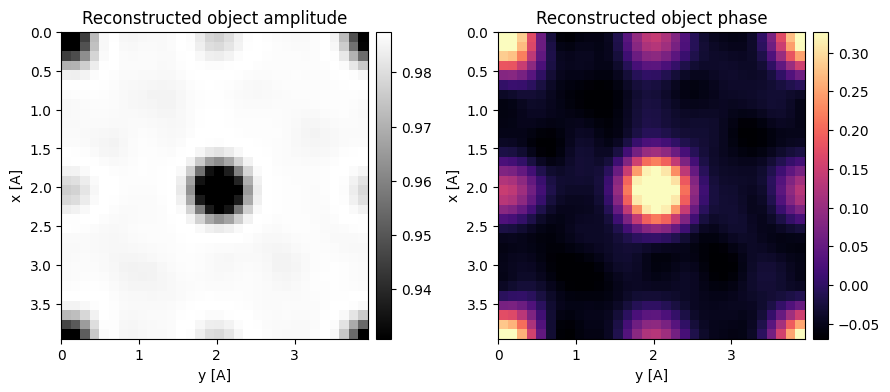

In [11]:
corner_centered_segmented_detector_masks = [np.fft.fftshift(mask.astype(np.bool_)) for mask in segmented_detector_masks]

segmented_ssb = py4DSTEM.process.phase.SSB(
    energy=energy,
    datacube=segmented_dataset,
    semiangle_cutoff=semiangle_cutoff,
    verbose=True,
).preprocess(
    plot_center_of_mass=False,
    plot_rotation=False,
    plot_overlap_trotters=False,
    force_com_rotation=-15,
    crop_around_bf_disk=False,
).reconstruct(
    virtual_detector_masks=corner_centered_segmented_detector_masks,
).visualize(
)

Calculating center of mass: 100%|██████████| 1024/1024 [00:00<00:00, 20018.12probe position/s]
Best fit rotation forced to -15 degrees.
100%|██████████| 1024/1024 [00:02<00:00, 440.38it/s]


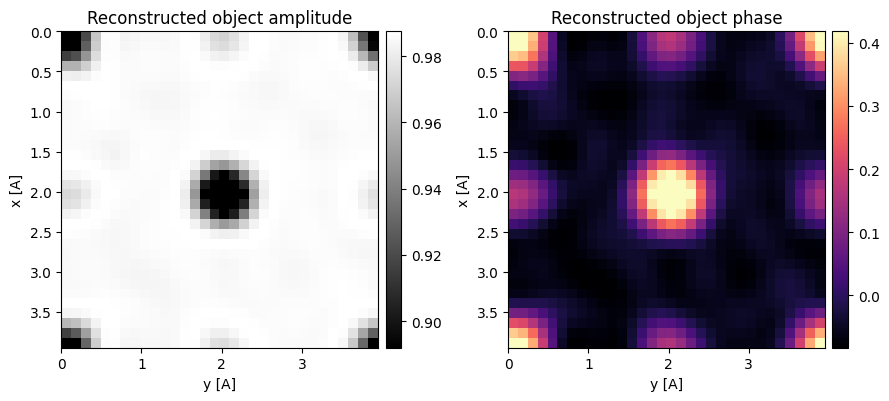

In [12]:
segmented_obf = py4DSTEM.process.phase.OBF(
    energy=energy,
    datacube=segmented_dataset,
    semiangle_cutoff=semiangle_cutoff,
    verbose=True,
).preprocess(
    plot_center_of_mass=False,
    plot_rotation=False,
    plot_overlap_trotters=False,
    force_com_rotation=-15,
    crop_around_bf_disk=False,
).reconstruct(
    virtual_detector_masks=corner_centered_segmented_detector_masks,
).visualize(
)

Indeed, the methods still work remarkably well!

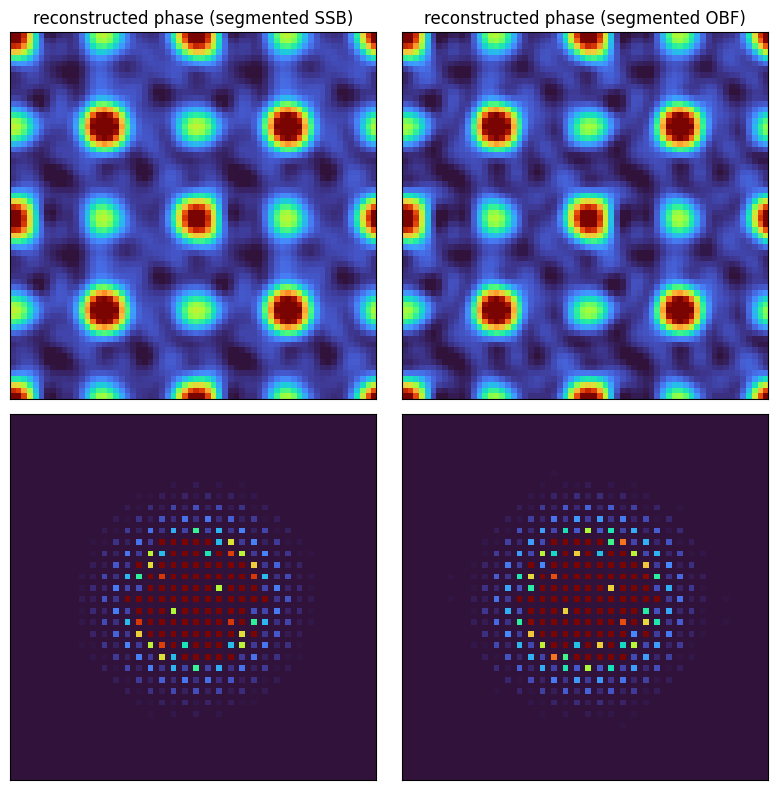

In [13]:
fig, axs = plt.subplots(2,2,figsize=(8,8))

for ax, arr, title in zip(
    axs[0],
    (np.angle(segmented_ssb.object),np.angle(segmented_obf.object)),
    ('reconstructed phase (segmented SSB)','reconstructed phase (segmented OBF)')
):
    py4DSTEM.show(
        np.tile(arr,(2,2)),
        figax=(fig,ax),
        cmap='turbo',
        ticks=False,
        title=title,
    )

for ax, arr in zip(
    axs[1],
    (np.angle(segmented_ssb.object),np.angle(segmented_obf.object))
):
    py4DSTEM.show(
        np.tile(arr,(2,2)),
        figax=(fig,ax),
        cmap='turbo',
        show_fft=True,
        apply_hanning_window=False,
        ticks=False,
    )

fig.tight_layout()